In [0]:
# Installing Keras Library and importing the same.
# Reference: https://keras.io/
from keras import backend as K

import time
# Matplot library used for plotting images and charts
import matplotlib.pyplot as plt

# Numpy is library used for efficient high level mathemtical processing on multi dimensional arrays
import numpy as np
% matplotlib inline
np.random.seed(2017) 

# Keras provides a Sequential model API. This is way of creating a linear stack of layers while creating models.
from keras.models import Sequential

# Convolution2D will be used to create a convolution kernel that is convolved with the layer input to produce a tensor of outputs
from keras.layers.convolutional import Convolution2D, MaxPooling2D

# Flatten provided by Keras will be used to convert a multidimensional tensor into a single 1-D tensor
from keras.layers import Activation, Flatten, Dropout
from keras.layers.normalization import BatchNormalization

# Import np_utils from keras
from keras.utils import np_utils

In [4]:
# Loads CIFAR10 dataset
# 'features' values will have images, 'labels' will have the names represented by the corresponding 'feature' image
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 9s 0us/step


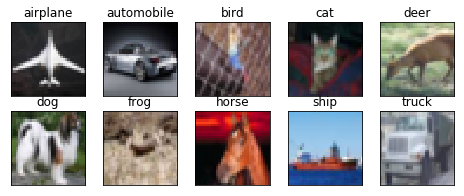

In [5]:
# Let's see some random features(images) with labels from training dataset
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# Function to plot charts showing 'Model Accuracy vs Epoch' and 'Model Loss vs Epoch'
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# Function to calculate the Test Accuracy on test dataset
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# Why Float32?
# Using a 32 bit precision is a common approach in neural network training.
# Reason behind is that to make sure that the dataset fits easily in RAM.

# Why dividing by 255?
# 255 is the max pixel value in an image. Dividing all pixel values by 255 ensures that the input features are scaled between 0.0 and 1.0
# Reason behind to scale between 0.0 and 1.0 is to make sure default learning rate works well.

train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [32]:
from keras.layers import Input, SeparableConv2D, concatenate
from keras.models import Model


inputs = Input(shape=(32, 32, 3))

#~~~~~~~~~~~~~~~~~~~~~NORMAL CONVOLUTION: STARTS~~~~~~~~~~~~~~~~~~~~~
######################BLOCK STARTS##############################################
# Input Dimension  = 32x32x3
# Kernel           = 3x3x3
# No:of Kernels    = 64
# Output Dimension = 32x32x64 (Here,64 is the number of channels)
# Receptive Field  = 3x3  
conv = Convolution2D(64, 3, 3, activation='relu', border_mode='same') (inputs)
batch_norm = BatchNormalization()(conv)
layer1 = Dropout(0.1)(batch_norm)
######################BLOCK ENDS################################################


######################BLOCK STARTS##############################################
# Input Dimension  = 32x32x64
# Kernel           = 3x3x64
# No:of Kernels    = 128
# Output Dimension = 32x32x128 (Here,128 is the number of channels)
# Receptive Field  = 5x5 
conv = Convolution2D(128, 3, 3, activation='relu', border_mode='same') (layer1)
batch_norm = BatchNormalization()(conv)
layer2 = Dropout(0.1)(batch_norm)
######################BLOCK ENDS################################################


######################BLOCK STARTS##############################################
# Input Dimension  = 32x32x96
# Kernel           = 3x3x96
# No:of Kernels    = 256
# Output Dimension = 32x32x256 (Here,256 is the number of channels)
# Receptive Field  = 7x7 
conv = Convolution2D(256, 3, 3, activation='relu', border_mode='same') (layer2)
batch_norm = BatchNormalization()(conv)
layer3 = Dropout(0.1)(batch_norm)
######################BLOCK ENDS################################################
#~~~~~~~~~~~~~~~~~~~~~NORMAL CONVOLUTION: ENDS~~~~~~~~~~~~~~~~~~~~~

######################TRANSITION BLOCK STARTS###################################
# Input Dimension  = 32x32x256
# Maxpooling Dimension = 2x2 (Default is 2x2)
# Output Dimension = 16x16x256 (Here,256 is the number of channels)
# Receptive Field  = 14x14 
# NOTE: Maxpooling halves the resolution and doubles the receptive field
conv = MaxPooling2D(pool_size=(2,2))(layer3)

# # Input Dimension  = 16x16x256
# # Kernel           = 1x1x256
# # No:of Kernels    = 64
# # Output Dimension = 16x16x64 (Here,64 is the number of channels)
# # Receptive Field  = 14x14
# # NOTE: 1x1 Kernels are used here for dimension(channel) reduction.
# # No effect on output resolution or receptive field
layer4 = Convolution2D(64, 1, 1)(conv)
######################TRANSITION BLOCK ENDS#####################################

#~~~~~~~~~~~~~~~~~~~DEPTH-WISE SEPARABLE CONVOLUTION: STARTS~~~~~~~~~~~~~~~~~~~~
######################BLOCK STARTS##############################################
# Input Dimension  = 16x16x64
# Kernel           = 3x3x64
# No:of Kernels    = 128
# Output Dimension = 16x16x128 (Here,128 is the number of channels)
# Receptive Field  = 16x128 
conv = SeparableConv2D(128, 3, 3, activation='relu', border_mode='same')(layer4)
batch_norm = BatchNormalization()(conv)
layer5 = Dropout(0.1)(batch_norm)
######################BLOCK ENDS################################################


######################BLOCK STARTS##############################################
# Input Dimension  = 16x16x96
# Kernel           = 3x3x96
# No:of Kernels    = 256
# Output Dimension = 16x16x256 (Here,256 is the number of channels)
# Receptive Field  = 18x18 
conv = SeparableConv2D(256, 3, 3, activation='relu', border_mode='same')(layer5)
batch_norm = BatchNormalization()(conv)
layer6 = Dropout(0.1)(batch_norm)
######################BLOCK ENDS################################################
#~~~~~~~~~~~~~~~~~~~DEPTH-WISE SEPARABLE CONVOLUTION: ENDS~~~~~~~~~~~~~~~~~~~~

######################TRANSITION BLOCK STARTS###################################
# Input Dimension  = 16x16x256
# Maxpooling Dimension = 2x2 (Default is 2x2)
# Output Dimension = 8x8x256 (Here,256 is the number of channels)
# Receptive Field  = 36x36 
# NOTE: Maxpooling halves the resolution and doubles the receptive field
conv = MaxPooling2D(pool_size=(2,2))(layer6)

# # Input Dimension  = 8x8x256
# # Kernel           = 1x1x256
# # No:of Kernels    = 64
# # Output Dimension = 8x8x64 (Here,64 is the number of channels)
# # Receptive Field  = 36x36
# # NOTE: 1x1 Kernels are used here for dimension(channel) reduction.
# # No effect on output resolution or receptive field
layer7 = Convolution2D(64, 1, 1)(conv)
layer7 = BatchNormalization()(layer7)
layer7 = Dropout(0.1)(layer7)
######################TRANSITION BLOCK ENDS#####################################

#~~~~~~~~~~~GROUPED CONVOLUTION(3x3 & 5x5: Without Dilation): STARTS~~~~~~~~~~~~
######################BLOCK STARTS##############################################
# Input Dimension  = 8x8x64
# Kernel           = 3x3x64
# No:of Kernels    = 128
# Output Dimension = 8x8x128 (Here,128 is the number of channels)
# Receptive Field  = 40x40 
group_conv3 = Convolution2D(128, 3, 3, border_mode='same', activation='relu') (layer7)   # Receptive Field  = 38x38 
group_conv3 = BatchNormalization()(group_conv3)
group_conv3 = Dropout(0.1)(group_conv3)

group_conv5 = Convolution2D(128, 5, 5, border_mode='same', activation='relu') (layer7)   # Receptive Field  = 40x40 
group_conv5 = BatchNormalization()(group_conv5)
group_conv5 = Dropout(0.1)(group_conv5)

layer8 = concatenate([group_conv3, group_conv5]) # Receptive Field  = 40x40


######################BLOCK ENDS################################################

#~~~~~~~~~~~GROUPED CONVOLUTION(3x3 & 5x5: Without Dilation): ENDS~~~~~~~~~~~~~~



######################TRANSITION BLOCK STARTS###################################
# Input Dimension  = 8x8x128
# Maxpooling Dimension = 2x2 (Default is 2x2)
# Output Dimension = 4x4x128 (Here,128 is the number of channels)
# Receptive Field  = 80x80 
# NOTE: Maxpooling halves the resolution and doubles the receptive field
conv = MaxPooling2D(pool_size=(2,2))(layer8)

# # Input Dimension  = 4x4x128
# # Kernel           = 1x1x128
# # No:of Kernels    = 64
# # Output Dimension = 4x4x64 (Here,64 is the number of channels)
# # Receptive Field  = 80x80
# # NOTE: 1x1 Kernels are used here for dimension(channel) reduction.
# # No effect on output resolution or receptive field
layer9 = Convolution2D(64, 1, 1)(conv)
layer9 = BatchNormalization()(layer9)
layer9 = Dropout(0.1)(layer9)
######################TRANSITION BLOCK ENDS#####################################



#~~~~~~~~~~~~~GROUPED CONVOLUTION(3x3 only: With Dilation): STARTS~~~~~~~~~~~~~~
######################BLOCK STARTS##############################################
# Input Dimension  = 4x4x64
# Kernel           = 3x3x64
# No:of Kernels    = 256
# Output Dimension = 4x4x256 (Here,112 is the number of channels)
# Receptive Field  = 84x84  
group_conv3_dilation_a = Convolution2D(256, 3, 3, border_mode='same', activation='relu', dilation_rate=(1, 1)) (layer9)   # Receptive Field  = 82x82 
group_conv3_dilation_a = BatchNormalization()(group_conv3_dilation_a)
group_conv3_dilation_a = Dropout(0.1)(group_conv3_dilation_a)

group_conv3_dilation_b = Convolution2D(256, 3, 3, border_mode='same', activation='relu', dilation_rate=(2, 2)) (layer9)   # Receptive Field  = 84x84 
group_conv3_dilation_b = BatchNormalization()(group_conv3_dilation_b)
group_conv3_dilation_b = Dropout(0.1)(group_conv3_dilation_b)

layer10 = concatenate([group_conv3_dilation_a, group_conv3_dilation_b]) # Receptive Field  = 44x44 
######################BLOCK ENDS################################################
#~~~~~~~~~~~~~GROUPED CONVOLUTION(3x3 only: With Dilation): ENDS~~~~~~~~~~~~~~~~


######################PREDICTION BLOCK STARTS###################################
# # Input Dimension  = 4x4x256
# # Kernel           = 1x1x256
# # No:of Kernels    = 10
# # Output Dimension = 4x4x10 (Here,10 is the number of channels)
# # Receptive Field  = 84x84
# # NOTE: 1x1 Kernels are used here for dimension(channel) reduction.
# # No effect on output resolution or receptive field
layer11 = Convolution2D(10,1,1)(layer10)
# Input Dimension  = 4x4x10
# Kernel           = 4x4x10
# No:of Kernels    = 10
# Output Dimension = 1x1x10 (Here,10 is the number of channels)
layer12 = Convolution2D(10,4,4)(layer11)

# Input Dimension  = 1x1x10
# Output Dimension = 10
outputs = Flatten()(layer12)
# We use a “softmax” activation function in the output layer. 
# This is to ensure the output values are in the range of 0 and 1 and used as predicted probabilities.
outputs= Activation('softmax')(outputs)
######################PREDICTION BLOCK ENDS#####################################
model = Model(inputs=[inputs], outputs=[outputs])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(128, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: Update your `SeparableConv2D` cal

In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_124 (Conv2D)             (None, 32, 32, 64)   1792        input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_93 (BatchNo (None, 32, 32, 64)   256         conv2d_124[0][0]                 
__________________________________________________________________________________________________
dropout_93 (Dropout)            (None, 32, 32, 64)   0           batch_normalization_93[0][0]     
__________________________________________________________________________________________________
conv2d_125

# Cyclic Learning Rate

In [0]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

# Training

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<__main__..., validation_data=(array([[[..., verbose=1, steps_per_epoch=195, epochs=50)`
  app.launch_new_instance()


Epoch 1/50
195/195 [==============================] - 49s 252ms/step - loss: 1.4420 - acc: 0.5010 - val_loss: 1.6059 - val_acc: 0.5048
Epoch 2/50
195/195 [==============================] - 47s 243ms/step - loss: 0.9049 - acc: 0.6813 - val_loss: 0.9775 - val_acc: 0.6889
Epoch 3/50
195/195 [==============================] - 49s 250ms/step - loss: 0.7117 - acc: 0.7507 - val_loss: 1.1759 - val_acc: 0.6557
Epoch 4/50
195/195 [==============================] - 49s 249ms/step - loss: 0.6071 - acc: 0.7868 - val_loss: 1.5378 - val_acc: 0.6041
Epoch 5/50
195/195 [==============================] - 49s 251ms/step - loss: 0.5457 - acc: 0.8112 - val_loss: 0.9870 - val_acc: 0.7166
Epoch 6/50
195/195 [==============================] - 49s 250ms/step - loss: 0.5011 - acc: 0.8239 - val_loss: 0.9366 - val_acc: 0.7337
Epoch 7/50
195/195 [==============================] - 49s 250ms/step - loss: 0.4622 - acc: 0.8382 - val_loss: 1.3407 - val_acc: 0.6833
Epoch 8/50
195/195 [==============================] - 4

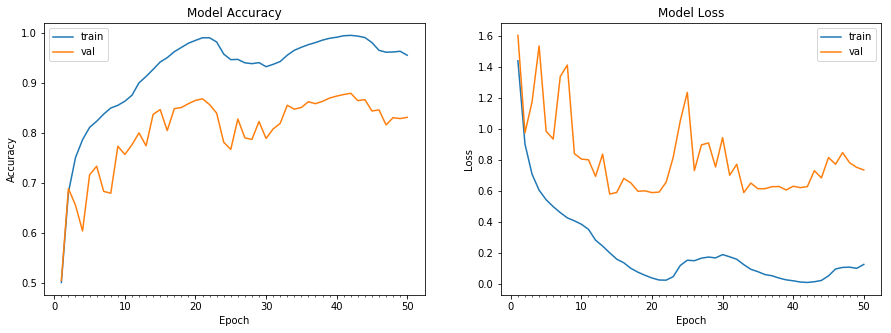

Accuracy on test data is: 83.17


In [31]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()


#Initialize Cyclic Learning Rate
from keras.callbacks import *
clr_triangular = CyclicLR(mode='triangular')

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
                                 callbacks=[clr_triangular],
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))